<a href="https://colab.research.google.com/github/dmburns1729/Class-Files/blob/main/Imbalanced_Classes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Weighting the classes to make predicting some classes more important than others

2. Randomly undersampling the data by removing samples in the larger class until there are the same number of each

3. Randomly oversampling the data by duplicating samples in the smaller class until there is the same number of each, or creating new samples that are similar to the ones in the smaller class.

4. Creating new synthetic data similar to the minority class using SMOTE

In [ ]:
#Imports
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

In [ ]:
#Load the data
df = pd.read_csv('https://docs.google.com/spreadsheets/d/e/2PACX-1vTFAKNYLfNuyIqnfUQDQbJ1UkFM_6FLHX14-M04ZQLc5Wg00yr5DMffrhbOPotC_aILgKtumtxzRBwh/pub?gid=1831091818&single=true&output=csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,154903,2.051787,-0.187022,-1.103035,0.426225,-0.269518,-1.170855,0.051066,-0.209313,0.806213,...,-0.303489,-0.819563,0.367881,-0.061352,-0.373009,0.206934,-0.079089,-0.064241,1.98,0
1,118132,-1.097036,-0.233782,-0.096022,-0.372325,2.434854,-1.393347,0.305382,-0.077793,-0.231507,...,0.207111,0.249741,-0.434478,-1.140822,1.381077,0.108243,-0.156596,-0.087092,21.23,0
2,5997,-1.451863,-0.924715,1.712229,-1.802891,0.176939,-1.201854,0.146044,0.055134,2.690959,...,0.007895,0.017067,0.183088,0.355935,0.284810,-0.131321,-0.017971,0.103671,115.59,0
3,138313,-0.748073,-1.209636,0.887484,-1.655591,-0.065690,0.957387,0.277554,0.327990,-0.835489,...,0.077620,-0.161395,0.725481,-1.080008,-0.305991,-0.477772,-0.028670,-0.003467,229.54,0
4,58067,-0.264869,3.386140,-3.454997,4.367629,3.336060,-2.053918,0.256890,-2.957235,-2.855797,...,-1.394504,-0.166029,-1.452081,-0.251815,1.243461,0.452787,0.132218,0.424599,1.00,1


In [ ]:
#Check class balance
df['Class'].value_counts(normalize=True)

0    0.99814
1    0.00186
Name: Class, dtype: float64

In [ ]:
#Train test split
X = df.drop(columns=['Class'])
y = df['Class']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     24955
           1       0.91      0.69      0.78        45

    accuracy                           1.00     25000
   macro avg       0.96      0.84      0.89     25000
weighted avg       1.00      1.00      1.00     25000



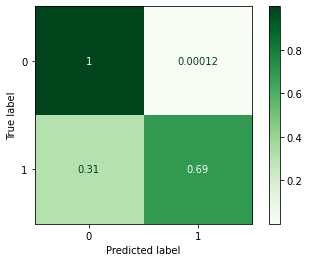

In [ ]:
#Create a baseline model pipeline
log_reg = LogisticRegression(max_iter=1000)
scaler = StandardScaler()
log_reg_pipe = make_pipeline(scaler, log_reg)
#Fit and evaluate the baseline model pipeline
log_reg_pipe.fit(X_train, y_train)
test_preds = log_reg_pipe.predict(X_test)
print(classification_report(y_test, test_preds))
ConfusionMatrixDisplay.from_predictions(y_test, test_preds, normalize='true', cmap='Greens');

Above was the tradtional modeling.  Notice that 31% of false negatives got through.  

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     24955
           1       0.07      0.96      0.13        45

    accuracy                           0.98     25000
   macro avg       0.53      0.97      0.56     25000
weighted avg       1.00      0.98      0.99     25000



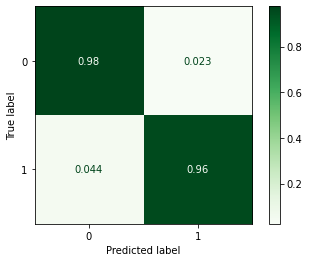

In [ ]:
# Class Weights

#Instantiate the pipeline with the scaler and weighted model
log_reg_weighted = LogisticRegression(max_iter=1000, class_weight='balanced')
scaler = StandardScaler()
log_reg_weighted_pipe = make_pipeline(scaler, log_reg_weighted)
#Fit and evaluate the model
log_reg_weighted_pipe.fit(X_train, y_train)
test_preds = log_reg_weighted_pipe.predict(X_test)
print(classification_report(y_test, test_preds))
ConfusionMatrixDisplay.from_predictions(y_test, test_preds, normalize='true', cmap='Greens');

# Undersampling

We can undersample our data by hand by separating the data into the classes by hand, using df.sample() to get a random sample of the majority class, then concatenating that back together with the samples from the majority class. OR, we can use the Imbalanced-Learn RandomUnderSampler class.<br>
<br>
The Scikit-Learn pipelines do not support the Imbalanced-Learn sampler objects. HOWEVER, Imbalanced-Learn has a pipeline that works with both Imbalanced-Learn objects AND Scikit-Learn ones. We are going to switch over to using the Imbalanced-Learn pipeline.<br>

The order of objects in the sampler pipeline will be:<br>

1. Transformer, preprocessing pipeline, or column transformer
2. Sampler
3. Model

We can also combine the fit and resample methods with .fit_resample(). Since this is a pipeline, keep in mind that the scaler will fit on the data, then send a transformed copy of the data to the resampler, which will then fit on the scaled data and the pipeline will return both resampled features and target.

In [ ]:
#import imblearn pipeline
from imblearn.pipeline import make_pipeline as make_sampler_pipeline
from imblearn.under_sampling import RandomUnderSampler

#create scaler and under sampler pipeline
under_sampler = RandomUnderSampler()
scaler = StandardScaler()
under_sample_pipe = make_sampler_pipeline(scaler, under_sampler)

#Compare the shape and value counts of the remaining data.
X_train_under, y_train_under = under_sample_pipe.fit_resample(X_train, y_train)
print('Original X_train class balance')
print(y_train.value_counts())
print('\nUndersampled X_train_under class balance')
y_train_under = pd.Series(y_train_under)
print(y_train_under.value_counts())

Original X_train class balance
0    74859
1      141
Name: Class, dtype: int64

Undersampled X_train_under class balance
0    141
1    141
Name: Class, dtype: int64


              precision    recall  f1-score   support

           0       1.00      0.96      0.98     24955
           1       0.04      0.98      0.07        45

    accuracy                           0.96     25000
   macro avg       0.52      0.97      0.53     25000
weighted avg       1.00      0.96      0.98     25000



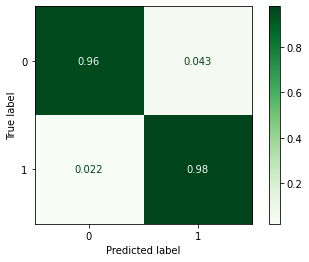

In [ ]:
#create the pipeline
log_reg_under = LogisticRegression(max_iter=1000)
under_sample_log_reg_pipe = make_sampler_pipeline(scaler, under_sampler, log_reg_under)

#Fit and evaluate the model
under_sample_log_reg_pipe.fit(X_train, y_train)
test_preds = under_sample_log_reg_pipe.predict(X_test)
print(classification_report(y_test, test_preds))
ConfusionMatrixDisplay.from_predictions(y_test, test_preds,normalize='true', cmap='Greens');

# Oversampling

When implementing oversampling we will introduce duplicates of the data in the minority class. You've been told to avoid duplicates in the past, and there are downsides to his approach. However, remember that we only resample training data, not testing data, so our model validation will not be compromised.

In [ ]:


#Import RandomOverSampling
from imblearn.over_sampling import RandomOverSampler
#Create an oversampling pipeline
over_sampler = RandomOverSampler()
over_sample_pipe = make_sampler_pipeline(scaler, over_sampler)
#Scale and oversample the data.
X_train_over, y_train_over = over_sample_pipe.fit_resample(X_train, y_train)
#Explore the sresampled data
print('Original X_train class balance')
print(y_train.value_counts())
print('\nOversampled X_train_over class balance')
y_train_over = pd.Series(y_train_over)
print(y_train_over.value_counts())

Original X_train class balance
0    74859
1      141
Name: Class, dtype: int64

Oversampled X_train_over class balance
0    74859
1    74859
Name: Class, dtype: int64


              precision    recall  f1-score   support

           0       1.00      0.98      0.99     24955
           1       0.07      0.96      0.13        45

    accuracy                           0.98     25000
   macro avg       0.53      0.97      0.56     25000
weighted avg       1.00      0.98      0.99     25000



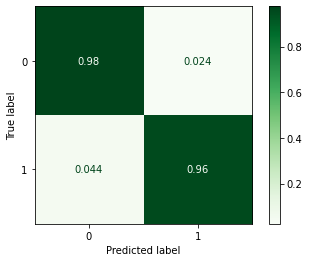

In [ ]:
#Create the oversampling modeling pipeline
log_reg_over = LogisticRegression(max_iter=1000)
over_sample_log_reg_pipe = make_sampler_pipeline(scaler, over_sampler, log_reg_over)
#Fit and evaluate the model
over_sample_log_reg_pipe.fit(X_train, y_train)
test_preds = over_sample_log_reg_pipe.predict(X_test)
print(classification_report(y_test, test_preds))
ConfusionMatrixDisplay.from_predictions(y_test, test_preds, normalize='true', cmap='Greens');

# Smote

SMOTE stands for Synthetic Minority Oversampling Technique. It's a powerful tool that creates new, synthetic data that is very similar to the data in the minority class. It does this by fitting a KNN model on the data and creating new data points that are near the center of the minority data cluster. In this way, the new, synthetic data is 'similar' to the original, real data.

              precision    recall  f1-score   support

           0       1.00      0.97      0.99     24955
           1       0.06      0.96      0.11        45

    accuracy                           0.97     25000
   macro avg       0.53      0.96      0.55     25000
weighted avg       1.00      0.97      0.98     25000



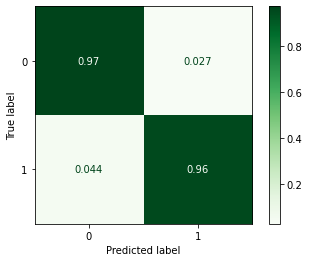

In [ ]:
#Create model pipeline with scaler, SMOTE, and model
from imblearn.over_sampling import SMOTE
smote = SMOTE()
log_reg_smote = LogisticRegression(max_iter=1000)
log_reg_smote_pipe = make_sampler_pipeline(scaler, smote, log_reg_smote)
#Fit and evaluate the model pipeline
log_reg_smote_pipe.fit(X_train, y_train)
test_preds = log_reg_smote_pipe.predict(X_test)
print(classification_report(y_test, test_preds))
ConfusionMatrixDisplay.from_predictions(y_test, test_preds,normalize='true',cmap='Greens');